In [949]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.metrics import pairwise_distances
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
from bs4 import BeautifulSoup
import requests
import codecs
from tqdm import tqdm
from multiprocessing.dummy import Pool, Lock, Queue
import pickle
from collections import namedtuple

In [73]:
import warnings
warnings.filterwarnings('ignore')

### Загрузка данных:

In [936]:
train_df = pd.read_csv('train_groups.csv')
test_df = pd.read_csv('test_groups.csv')

In [5]:
doc_to_title = {}
with open('docs_titles.tsv', encoding='UTF-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title

### Функции для сохранения данных:

In [939]:
from helpers import save_obj, load_obj

### Загрузка и сохранение информации о веб-страницах:

In [940]:
from helpers import WebDocInfo, get_url, get_web_doc_info, web_doc_info_process

In [11]:
doc_ids = train_df.doc_id.drop_duplicates()

In [35]:
dict_web_doc_info = {}
for doc_id in tqdm(doc_ids):
    web_doc_info_process(doc_id, False)

100%|████████████████████████████████████████████████████████████████████████████| 11648/11648 [49:58<00:00,  3.88it/s]


In [37]:
save_obj(dict_web_doc_info, 'dict_web_doc_info_train')

## Обработка и сохранение предобработанных документов:

In [16]:
stemmer_rus = SnowballStemmer("russian")
stop_words = set(stopwords.words(["russian"]))

### Обработка заголовков (стемминг):

In [ ]:
import from helpers get_preprocessed_title, doc_title_process

In [ ]:
doc_titles = doc_to_title.copy()

In [ ]:
doc_ids = doc_titles.keys()

In [ ]:
doc_titles_processed = {}
with Pool(processes=8) as pool, tqdm(total=len(doc_ids)) as pbar:
    lock = pbar.get_lock()
    pool.map(doc_title_process, doc_ids)
pool.join()

In [ ]:
save_obj(doc_titles_processed, 'doc_titles_processed')

### Извлекаем текст из body веб-страницы:

In [938]:
from helpers import get_body, get_preprocessed_text, get_preprocessed_text_wo_stop_words, doc_text_process
from helpers import doc_text_process_wo_stop_words, doc_text_process_safe, doc_text_process_wo_stop_words_safe

#### Обработка Train:

In [26]:
dict_doc_text = {}

In [27]:
with Pool(processes=16) as pool, tqdm(total=len(doc_ids)) as pbar:
    lock = pbar.get_lock()
    pool.map(doc_text_process_safe, doc_ids)
pool.join()

100%|██████████████████████████████████████████████████████████████████████████| 11648/11648 [3:00:28<00:00,  1.08it/s]


In [29]:
save_obj(dict_doc_text, 'dict_doc_text_train')

#### Удаляем стоп-слова:

In [45]:
dict_doc_text_wo_stop_words = {}

In [46]:
with Pool(processes=16) as pool, tqdm(total=len(doc_ids)) as pbar:
    lock = pbar.get_lock()
    pool.map(doc_text_process_wo_stop_words_safe, doc_ids)
pool.join()

100%|███████████████████████████████████████████████████████████████████████████| 11648/11648 [00:39<00:00, 298.30it/s]


In [50]:
save_obj(dict_doc_text_wo_stop_words, 'dict_doc_text_wo_stop_words_train')

### Обработка Test:

In [14]:
doc_ids = test_df.doc_id.drop_duplicates()

In [54]:
dict_doc_text = {}

In [55]:
with Pool(processes=16) as pool, tqdm(total=len(doc_ids)) as pbar:
    lock = pbar.get_lock()
    pool.map(doc_text_process_safe, doc_ids)
pool.join()

100%|██████████████████████████████████████████████████████████████████████████| 16503/16503 [4:29:04<00:00,  1.02it/s]


In [ ]:
save_obj(dict_doc_text, 'dict_doc_text_test')

In [11]:
dict_doc_text = load_obj('dict_doc_text_test')

#### Удаляем стоп-слова:

In [12]:
dict_doc_text_wo_stop_words = {}

In [24]:
with Pool(processes=16) as pool, tqdm(total=len(doc_ids)) as pbar:
    lock = pbar.get_lock()
    pool.map(doc_text_process_wo_stop_words_safe, doc_ids)
pool.join()

100%|███████████████████████████████████████████████████████████████████████████| 16503/16503 [00:45<00:00, 362.05it/s]


In [25]:
save_obj(dict_doc_text_wo_stop_words, 'dict_doc_text_wo_stop_words_test')

### Извлекаем из текстов (body) топ 10 слов, результат конкатенируем c title:

In [37]:
from helpers import get_content_top_words, get_corpus

In [35]:
doc_titles_processed = load_obj('doc_titles_processed')
dict_doc_text_wo_stop_words_train = load_obj('dict_doc_text_wo_stop_words_train')
dict_doc_text_wo_stop_words_test = load_obj('dict_doc_text_wo_stop_words_test')

In [858]:
dict_doc_text_train = load_obj('dict_doc_text_train')
dict_doc_text_test = load_obj('dict_doc_text_test')

#### Каждый документ представляется в виде:  топ 10 слов body + title

In [415]:
train_corpus = get_corpus(doc_ids_train, dict_doc_text_wo_stop_words_train)
save_obj(train_corpus, 'train_corpus')

100%|████████████████████████████████████████████████████████████████████████████| 11648/11648 [03:14<00:00, 60.03it/s]


In [416]:
test_corpus = get_corpus(doc_ids_test, dict_doc_text_wo_stop_words_test)
save_obj(test_corpus, 'test_corpus')

100%|████████████████████████████████████████████████████████████████████████████| 16503/16503 [05:25<00:00, 50.66it/s]


In [417]:
train_corpus = load_obj('train_corpus')
test_corpus = load_obj('test_corpus')

## Анализ датасета и конструирование признаков

### Соотношение между выбросами и настоящими документами в группах:

In [603]:
target_grouped = train_df.groupby('group_id')['target'].sum().to_frame().reset_index()

<AxesSubplot:>

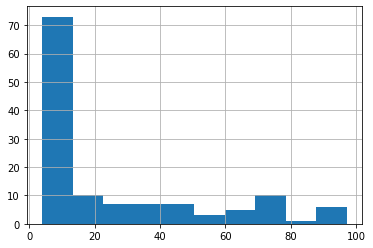

In [606]:
target_grouped.target.hist(bins = 10)

Группы в основном состоят из выбросов, то есть в основном в каждой группе выбросов больше, чем настоящих объектов.  

In [611]:
sum(train_df.groupby('group_id')['target'].sum() < 20)

81

Кол-во групп, в которых настоящих объектов меньше 20, равно 81.

In [616]:
train_df.groupby('group_id')['target'].sum().median()

10.0

Медиана по кол-ву настоящих объектов в группах равна 10.

### Косинусное расстояние между векторами текстов tf-idf:

Будем брать в качестве признаков расстояния до 20 ближайших документов.  

In [922]:
train_df_grouped = train_df.groupby("group_id")

In [1125]:
n_grp = 1

In [1126]:
doc_indices = dict(train_df_grouped.groups.items())[n_grp]

In [1127]:
X_train_grp = X_train_20[doc_indices]
y_train_grp = train_df.iloc[doc_indices].target

In [916]:
"Кол-во настоящих объектов: {}".format(len(y_train_1[y_train_1 == 1]))

'Кол-во настоящих объектов: 8'

Text(0.5, 1.0, 'Расстояние после шкалирования')

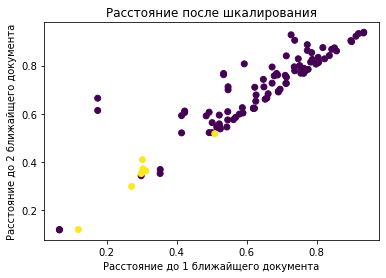

In [1128]:
plt.scatter(X_train_grp[:, 0], X_train_grp[:, 1], c=y_train_grp)
plt.xlabel('Расстояние до 1 ближайщего документа')
plt.ylabel('Расстояние до 2 ближайщего документа')
plt.title('Расстояние после шкалирования')

Настоящие объекты расположены ниже и левее на графике.  
Но при этом часть выбросов также попадает в эту область.

#### Анализ отличий между выбросами и настоящими объектами:

In [549]:
import fasttext
from sklearn.metrics.pairwise import cosine_similarity
import spacy

In [563]:
train_df[((train_df.group_id == 1))]

,pair_id,group_id,doc_id,target,is_redirect,is_accessible
0,1,1,15731,0,0,1
1,2,1,14829,0,1,1
2,3,1,15764,0,1,1
3,4,1,17669,0,0,0
4,5,1,14852,0,1,1
...,...,...,...,...,...,...
97,98,1,16184,0,0,0
98,99,1,17050,1,1,1
99,100,1,15734,0,1,1
100,101,1,16407,0,0,0


#### Выброс:

In [579]:
train_corpus[15731]

'подшипник 16 ступиц поворотн кулак снят тормозн кольц передн рычаг ваз 21213 зам подшипник ступиц нив'

In [597]:
doc_to_title[15731]

'ВАЗ 21213 | Замена подшипников ступицы | Нива'

#### Настоящий объект:

In [580]:
train_corpus[17050]

'18 подшипник ступиц поворотн кулак снят передн тормозн кольц рычаг ваз 2121 зам подшипник ступиц'

In [598]:
doc_to_title[17050]

'ВАЗ 2121 Замена подшипников ступицы'

In [550]:
nlp = spacy.load("ru_core_news_sm")

In [593]:
doc_nlp_outliner = nlp(train_corpus[15731]).vector
doc_nlp = nlp(train_corpus[17050]).vector

In [594]:
cosine_similarity([doc_nlp_outliner], [doc_nlp])

array([[0.9784919]], dtype=float32)

In [1115]:
cosine_similarity([X_train_20[0]], [X_train_20[98]])

array([[0.99852968]])

Косинусная мера близка к единице между текстами выброса и настоящего объекта.  
Визуально тексты также очень похожи.

Построенная модель model_80 (CatBoostClassifier) не может определить, что "15731.dat" является выбросом.

In [1110]:
model_20.predict(X_train_web_20[0]), model_20.predict(X_train_web_20[98]) 

(0, 1)

In [1111]:
model_80.predict(X_train_web_80[0]), model_80.predict(X_train_web_80[98]) 

(1, 1)

In [1112]:
model_80_wo_web.predict(X_train_s_80[0]), model_80_wo_web.predict(X_train_s_80[98]) 

(1, 1)

#### Замечание:

Не понятно почему документ "15731.dat" является выбросом.  
Поскольку по содержанию очень похож на настоящий документ "17050.dat".

#### Использование статистик по каждой группе в качестве признаков:

Предлагается использовать статистики по признакам (расстояниям) в каждой группе отдельно:  
стандартное отклонение, среднее, медиана.

In [924]:
n_grp1 = 20
n_grp2 = 100

In [1104]:
doc_indices_grp_1 = dict(train_df_grouped.groups.items())[n_grp1]
doc_indices_grp_2 = dict(train_df_grouped.groups.items())[n_grp2]
d_grp_1 = X_train_80[doc_indices_grp_1, 0]
d_grp_2= X_train_80[doc_indices_grp_2, 0]

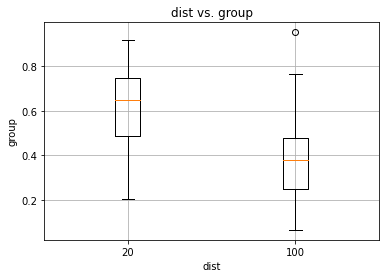

In [1105]:
data = [d_grp_1, d_grp_2]
fig, ax = plt.subplots()
ax.set_title('dist vs. group')
ax.boxplot(data, labels=[n_grp1, n_grp2])
plt.grid()
plt.xlabel('dist')
plt.ylabel('group')
plt.show()

In [681]:
len(train_df[((train_df.group_id == 20) & (train_df.target == 1))]), \
len(train_df[((train_df.group_id == 100) & (train_df.target == 1))])

(5, 72)

В группе "100" больше настоящих объектов, чем в "20".  
Настоящие объекты по идее "кучнее" должны быть расположены.  
Значит, std, mediana, mean по расстоянию до ближайшего объекта  должны быть меньше, чем в "20".  
Поэтому если, например, mean у нас по "признаку 0" меньше какого-то порога, то мы можем считать, что  
объект относится к группе, где больше "настоящих" объектов,  
то есть в первом приближении считать объект "настоящим".

### Создание признаков:

In [941]:
train_corpus = load_obj('train_corpus')
test_corpus = load_obj('test_corpus')

In [932]:
from sklearn.preprocessing import StandardScaler

In [974]:
from helpers import add_to_df_web_info, fill_grp_20, fill_grp_80, fill_grp_80_simple
from helpers import get_X_20, get_X_80, get_X_80_simple, get_X_web

###  Добавление признаков: is_resirect, is_accessible:

In [946]:
dict_web_doc_info_test = load_obj('dict_web_doc_info_test')
dict_web_doc_info_train = load_obj('dict_web_doc_info_train')

add_to_df_web_info(train_df, dict_web_doc_info_train)
add_to_df_web_info(test_df, dict_web_doc_info_test)

### Расстояния до 20 ближайших документов + web признаки:

In [958]:
X_train_web_20, X_train_s_20, X_train_20 = get_X_20(train_df, train_corpus)

### Расстояния до 20 ближайших документов + std, mean, mediana по группам + web признаки:

In [964]:
X_train_web_80, X_train_s_80, X_train_80 = get_X_80(train_df, train_corpus)

In [968]:
y_train = train_df.target

### Разбиение Train на обучающую выборку (t) и на валидационную (val):

In [973]:
from helpers import get_t_val_indices

Для валидации берем произвольные 30 групп из train, остальные 99 групп используем для кроосс-валидации:

In [970]:
grp_val_indices = np.random.choice(129, 30, replace=False)
t_indices, val_indices = get_t_val_indices(train_df, grp_val_indices)
val_df = train_df.iloc[val_indices]
t_df = train_df.iloc[t_indices]

In [975]:
X_t_web_20 = get_X_web(X_train_s_20, train_df, t_indices)
X_t_s_20 = X_train_s_20[t_indices]
X_val_web_20 = get_X_web(X_train_s_20, train_df, val_indices)
X_val_s_20 = X_train_s_20[val_indices]

X_t_web_80 = get_X_web(X_train_s_80, train_df, t_indices)
X_t_s_80 = X_train_s_80[t_indices]
X_val_web_80 = get_X_web(X_train_s_80, train_df, val_indices)
X_val_s_80 = X_train_s_80[val_indices]

In [976]:
y_t = t_df.target
y_val = val_df.target

**В качестве модели используем CatBoostClassifier:**

In [977]:
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost

**5-фолдная кросс-валидация на 99 группах:**

In [993]:
import hyperopt
from numpy.random import RandomState

In [1035]:
def hyperopt_objective_20(params):
    model = CatBoostClassifier(thread_count=8,
                               l2_leaf_reg=int(params['l2_leaf_reg']),
                               learning_rate=params['learning_rate'],
                               iterations=int(params['iterations']),
                               depth=int(params['depth']),
                               eval_metric='F1',
                               random_seed=42,
                               verbose=False,
                               loss_function='Logloss')
    
    cv_data = catboost.cv(
        catboost.Pool(X_t_web_20, y_t, cat_features=[20, 21], group_id = t_df.group_id),
        model.get_params(),
        shuffle=True,
        fold_count=5,
        stratified=False
    )
    best_f1 = np.max(cv_data['test-F1-mean'])
    
    return 1 - best_f1 # as hyperopt minimises
 
def hyperopt_objective_80(params):
    model = CatBoostClassifier(thread_count=8,
                               l2_leaf_reg=int(params['l2_leaf_reg']),
                               learning_rate=params['learning_rate'],
                               iterations=int(params['iterations']),
                               depth=int(params['depth']),
                               eval_metric='F1',
                               random_seed=42,
                               verbose=False,
                               loss_function='Logloss')
    
    cv_data = catboost.cv(
        catboost.Pool(X_t_web_80, y_t, cat_features=[80, 81], group_id = t_df.group_id),
        model.get_params(),
        shuffle=True,
        fold_count=5,
        stratified=False
    )
    best_f1 = np.max(cv_data['test-F1-mean'])
    
    return 1 - best_f1 # as hyperopt minimises

def hyperopt_objective_80_wo_web(params):
    model = CatBoostClassifier(thread_count=8,
                               l2_leaf_reg=int(params['l2_leaf_reg']),
                               learning_rate=params['learning_rate'],
                               iterations=int(params['iterations']),
                               depth=int(params['depth']),
                               eval_metric='F1',
                               random_seed=42,
                               verbose=False,
                               loss_function='Logloss')
    
    cv_data = catboost.cv(
        catboost.Pool(X_t_s_80, y_t, cat_features=[], group_id = t_df.group_id),
        model.get_params(),
        shuffle=True,
        fold_count=5,
        stratified=False
    )
    best_f1 = np.max(cv_data['test-F1-mean'])
    
    return 1 - best_f1 # as hyperopt minimises

In [1036]:
params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-2, 5e-1),
    'depth': (1 + hyperopt.hp.uniform('depth', 3, 10)),
    'iterations': (1 + hyperopt.hp.uniform('iterations', 4, 50)),
}

trials = hyperopt.Trials()

best_20 = hyperopt.fmin(
    hyperopt_objective_20,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=80,
    trials=trials,
    rstate=RandomState(123)
)

100%|██████████████████████████████████████████████████| 80/80 [06:58<00:00,  5.23s/trial, best loss: 0.25712582411428]


In [1037]:
best_20

{'depth': 5.651209562019351,
 'iterations': 45.19956234035183,
 'l2_leaf_reg': 1.0,
 'learning_rate': 0.1784105589602183}

In [998]:
trials = hyperopt.Trials()

best_80 = hyperopt.fmin(
    hyperopt_objective_80,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=80,
    trials=trials,
    rstate=RandomState(123)
)

100%|███████████████████████████████████████████████| 80/80 [24:35<00:00, 18.44s/trial, best loss: 0.24133453102149405]


In [999]:
best_80

{'depth': 8.33161004556447,
 'iterations': 39.97931078522098,
 'l2_leaf_reg': 6.0,
 'learning_rate': 0.11000520760631624}

In [1009]:
trials = hyperopt.Trials()

best_80_wo_web = hyperopt.fmin(
    hyperopt_objective_80_wo_web,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=80,
    trials=trials,
    rstate=RandomState(123)
)

100%|███████████████████████████████████████████████| 80/80 [04:41<00:00,  3.51s/trial, best loss: 0.24949010898780744]


In [1011]:
best_80_wo_web

{'depth': 4.351981722413607,
 'iterations': 49.36681023366074,
 'l2_leaf_reg': 2.0,
 'learning_rate': 0.11529642431842818}

In [1087]:
model_20 = CatBoostClassifier(thread_count=8,
                              l2_leaf_reg=int(best_20['l2_leaf_reg']),
                              learning_rate=best_20['learning_rate'],
                              iterations=int(best_20['iterations']),
                              depth=int(best_20['depth']))

In [1088]:
model_80 = CatBoostClassifier(thread_count=8,
                              l2_leaf_reg=int(best_80['l2_leaf_reg']),
                              learning_rate=best_80['learning_rate'],
                              iterations=int(best_80['iterations']),
                              depth=int(best_80['depth']))

In [1089]:
model_80_wo_web = CatBoostClassifier(thread_count=8,
                                     l2_leaf_reg=int(best_80_wo_web['l2_leaf_reg']),
                                     learning_rate=best_80_wo_web['learning_rate'],
                                     iterations=int(best_80_wo_web['iterations']),
                                     depth=int(best_80_wo_web['depth']))

**model_20 на кросс-валидации:**

In [1090]:
model_20.fit(X_t_web_20, y_t, verbose=False, cat_features=[20, 21])
y_t_pred_20 = model_20.predict(X_t_web_20)
model_20_cv_f1 = f1_score(y_t, y_t_pred_20)
model_20_cv_f1

0.7780623132735808

**model_20 на отложенной выборке:**

In [1091]:
model_20.fit(X_t_web_20, y_t, verbose=False, cat_features=[20, 21])
y_val_pred_20 = model_20.predict(X_val_web_20)
model_20_test_f1 = f1_score(y_val, y_val_pred_20)
model_20_test_f1

0.6758304696449026

**На Liderboard sub_cb_20.csv - 0.71987**

**model_80 на кросс-валидации:**

In [1092]:
model_80.fit(X_t_web_80, y_t, verbose=False, cat_features=[80, 81])
y_t_pred_80 = model_80.predict(X_t_web_80)
model_80_cv_f1 = f1_score(y_t, y_t_pred_80)
model_80_cv_f1

0.8282955499580186

**model_80 на отложенной выборке:**

In [1093]:
model_80.fit(X_t_web_80, y_t, verbose=False, cat_features=[80, 81])
y_val_pred_80 = model_80.predict(X_val_web_80)
model_80_test_f1 = f1_score(y_val, y_val_pred_80)
model_80_test_f1

0.6367601246105918

**На Liderboard sub_80.csv - 0.74678**

**model_80_wo_web на кросс-валидации:**

In [1096]:
model_80_wo_web.fit(X_t_s_80, y_t, verbose=False, cat_features=[])
y_t_pred_80_wo_web = model_80_wo_web.predict(X_t_s_80)
model_80_wo_web_cv_f1 = f1_score(y_t, y_t_pred_80_wo_web)
model_80_wo_web_cv_f1

0.8049351201871942

**model_80_wo_web на отложенной выборке:**

In [1097]:
model_80_wo_web.fit(X_t_s_80, y_t, verbose=False, cat_features=[])
y_val_pred_80_wo_web = model_80_wo_web.predict(X_val_s_80)
model_80_wo_web_test_f1 = f1_score(y_val, y_val_pred_80_wo_web)
model_80_wo_web_test_f1

0.6569872958257713

**На Liderboard sub_80_wo_web.csv - 0.73605**

In [1098]:
feature_importances_20 = model_20.get_feature_importance()
feature_names_20 = range(22)

for score, name in sorted(zip(feature_importances_20, feature_names_20), reverse=True)[:10]:
    print('{}: {}'.format(name, score))

1: 11.88180957690874
2: 11.617603981064034
19: 9.19470936075975
20: 7.836276257209228
0: 7.712670884582694
4: 6.534199803656132
8: 5.822366701449409
5: 5.645703504980219
11: 4.281900381952004
15: 4.004237528637544


In [1099]:
feature_importances_80 = model_80.get_feature_importance()
feature_names_80 = range(82)

for score, name in sorted(zip(feature_importances_80, feature_names_80), reverse=True)[:10]:
    print('{}: {}'.format(name, score))

2: 7.9569476477852765
3: 7.823549413918691
80: 5.304872312015004
43: 5.041003465845854
0: 4.562224174913974
1: 3.935204809150055
40: 3.122445955091863
19: 2.4338030805872592
4: 2.3525444257113244
53: 2.003431256930842


In [1100]:
feature_importances_80_wo_web = model_80_wo_web.get_feature_importance()
feature_names_80_wo_web = range(80)

for score, name in sorted(zip(feature_importances_80_wo_web, feature_names_80_wo_web), reverse=True)[:10]:
    print('{}: {}'.format(name, score))

0: 10.048229292345507
1: 9.634718972540844
6: 8.252967481940416
5: 7.16909886003722
9: 5.309951565981519
3: 5.041768948515201
8: 3.983444996444356
4: 3.9307938042958304
27: 3.2388131682902244
20: 2.718336952180136


## Итого:

In [1102]:
data = {'model':['20 признаков + web признаки', '80 признаков + web признаки', '80 признаков - web признаки'],
        'cross-val': [model_20_cv_f1, model_80_cv_f1, model_80_wo_web_cv_f1],
        'test': [model_20_test_f1, model_80_test_f1, model_80_wo_web_test_f1], 
        'liderboard': [0.71987, 0.74678, 0.73605],
        'file': ['sub_cb_20.csv', 'sub_80.csv', 'sub_80_wo_web.csv']}

In [1103]:
pd.DataFrame.from_dict(data)

,model,cross-val,test,liderboard,file
0,20 признаков + web признаки,0.778062,0.675830,0.71987,sub_cb_20.csv
1,80 признаков + web признаки,0.828296,0.636760,0.74678,sub_80.csv
2,80 признаков - web признаки,0.804935,0.656987,0.73605,sub_80_wo_web.csv


**Лучшая модель: 80 признаков + web признаки**

## Submission:

In [1017]:
X_test_web_20, X_test_s_20, X_test_20 = get_X_20(test_df, test_corpus)
X_test_web_80, X_test_s_80, X_test_80 = get_X_80(test_df, test_corpus)

In [1061]:
model_20 = CatBoostClassifier(thread_count=8,
                              l2_leaf_reg=int(best_20['l2_leaf_reg']),
                              learning_rate=best_20['learning_rate'],
                              iterations=int(best_20['iterations']),
                              depth=int(best_20['depth']))
model_20.fit(X_train_web_20, y_train, verbose=False, cat_features=[20, 21])

In [1062]:
model_80 = CatBoostClassifier(thread_count=8,
                              l2_leaf_reg=int(best_80['l2_leaf_reg']),
                              learning_rate=best_80['learning_rate'],
                              iterations=int(best_80['iterations']),
                              depth=int(best_80['depth']))
model_80.fit(X_train_web_80, y_train, verbose=False, cat_features=[80, 81])

In [1063]:
model_80_wo_web = CatBoostClassifier(thread_count=8,
                                     l2_leaf_reg=int(best_80_wo_web['l2_leaf_reg']),
                                     learning_rate=best_80_wo_web['learning_rate'],
                                     iterations=int(best_80_wo_web['iterations']),
                                     depth=int(best_80_wo_web['depth']))
model_80_wo_web.fit(X_train_s_80, y_train, verbose=False, cat_features=[])

In [1064]:
y_pred_20 = model_20.predict(X_test_web_20)

In [1065]:
y_pred_80 = model_80.predict(X_test_web_80)

In [1066]:
y_pred_80_wo_web = model_80_wo_web.predict(X_test_s_80)

In [1080]:
y_pred_20.sum(), y_pred_80.sum(), y_pred_80_wo_web.sum()

(4409, 4509, 4409)

In [1076]:
y_pred = (y_pred_20 + y_pred_80 + y_pred_80_wo_web) / 3
y_pred = y_pred > 0.5

In [1079]:
y_pred = y_pred_80_wo_web
y_pred = np.array(y_pred, dtype=np.int)
with open('sub_80_wo_web.csv', 'w') as f:
    fieldnames = ['pair_id', 'target']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    i = 11691
    for elem in y_pred:
        writer.writerow({'pair_id': str(i), 'target': str(elem)})
        i += 1
f.close()

## На Liderboard:

'sub_vote_sh.csv' - 0.74706  
'sub_80.csv' - 0.74678  
'sub_80_wo_web.csv' - 0.73605  
'sub_cb_20.csv' - 0.71987  